In [1]:
import torch
import torch.nn as nn
#from res.plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis
from matplotlib import pyplot as plt
import numpy as np

In [2]:
figsize=(10,10)
dpi = 100
plt.style.use(['dark_background', 'bmh'])
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize=figsize, dpi=dpi)

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [4]:
def show_scatterplot(X, colors, title=''):
    colors = colors.cpu().numpy()
    X = X.cpu().numpy()
    plt.figure()
    plt.axis('equal')
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=30)
    # plt.grid(True)
    plt.title(title)
    plt.axis('off')
    
def plot_bases(bases, width=0.04):
    bases = bases.cpu()
    bases[2:] -= bases[:2]
    plt.arrow(*bases[0], *bases[2], width=width, color=(1,0,0), zorder=10, alpha=1., length_includes_head=True)
    plt.arrow(*bases[1], *bases[3], width=width, color=(0,1,0), zorder=10, alpha=1., length_includes_head=True)    

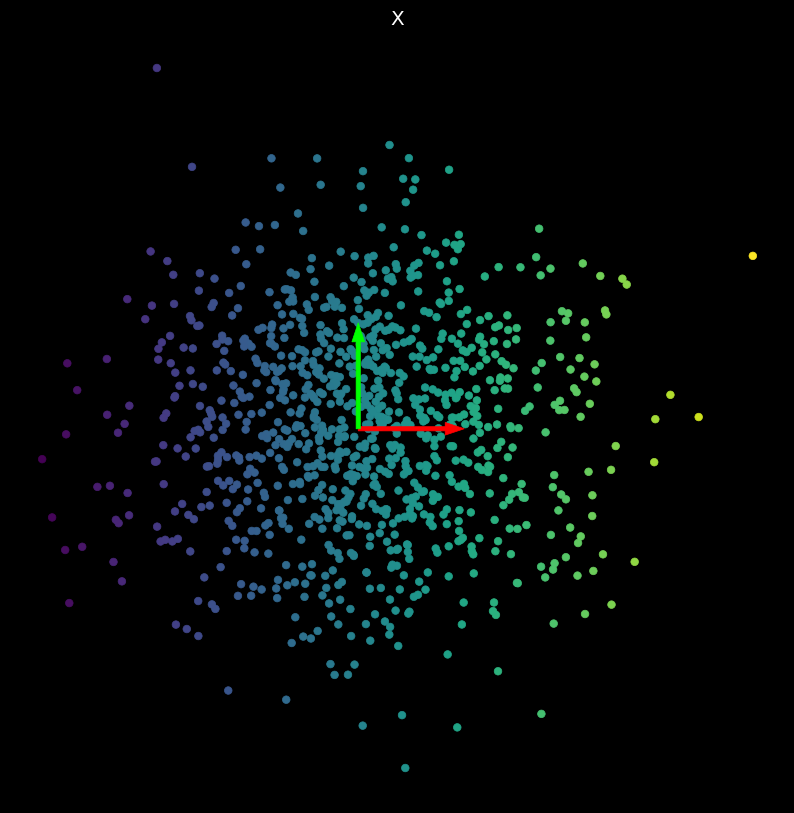

In [32]:
# generate some points in 2-D space
n_points = 1000
X = torch.randn(n_points, 2).to(device)
colors = X[:, 0]

show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)
plot_bases(OI)

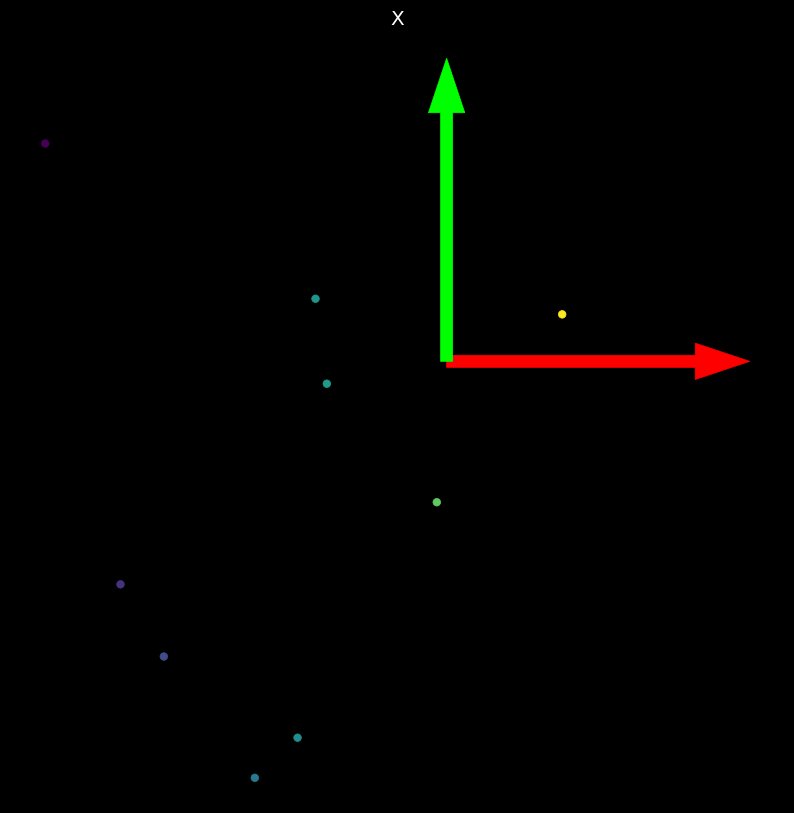

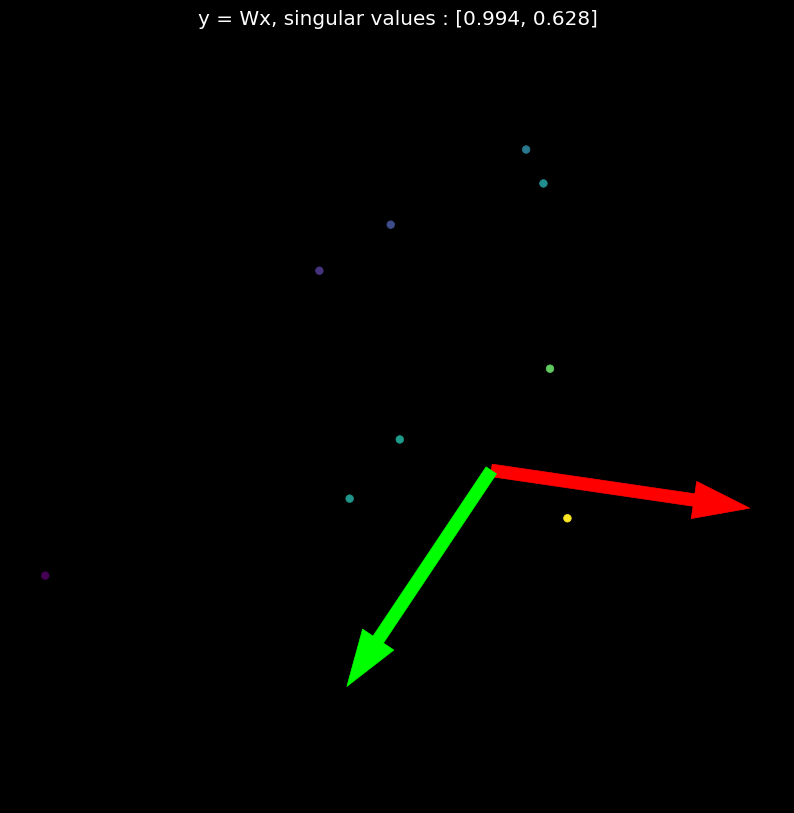

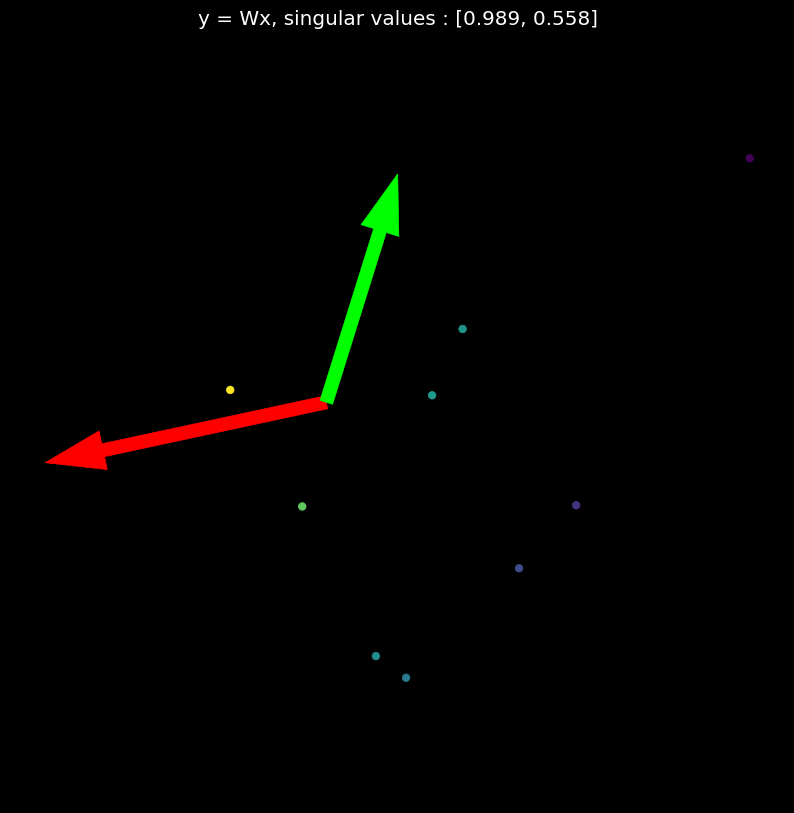

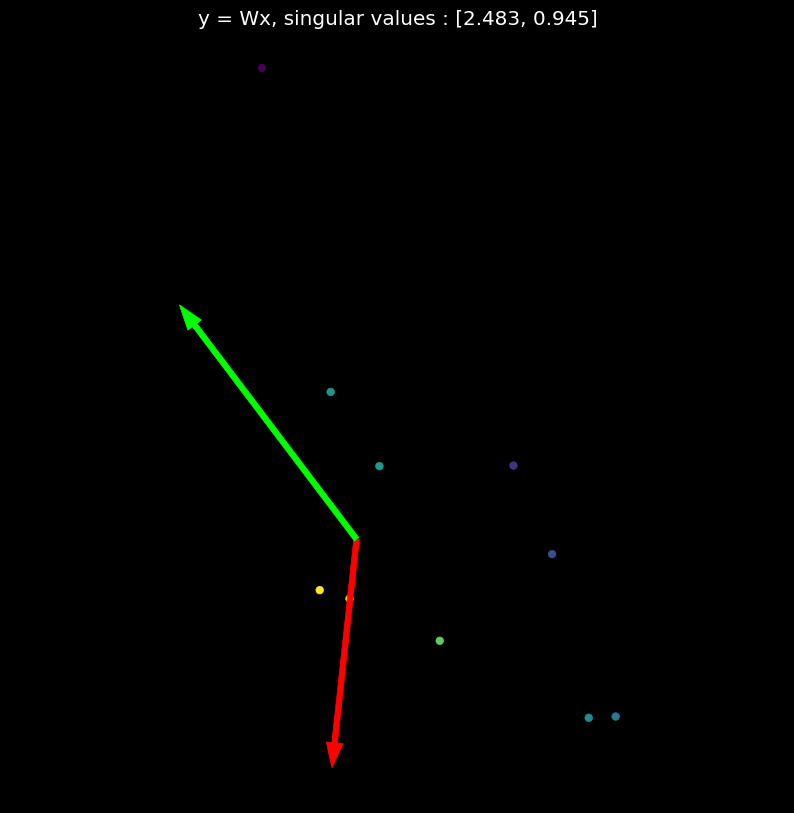

In [31]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)
torch.seed()
for i in range(3):
    # create a random matrix
    W = torch.randn(2, 2).to(device)
    # transform points
    Y = X @ W.t()
    # compute singular values
    U, S, V = torch.svd(W)
    # reconstructed W
    # reconstructed W
    rW = torch.matmul(torch.matmul(U, torch.diag_embed(S)), V.mT)
    torch.testing.assert_allclose(W, rW)
    # plot transformed points
    show_scatterplot(Y, colors, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    # transform the basis
    new_OI = OI @ W.t()
    # plot old and new basis
    #plot_bases(OI)
    plot_bases(new_OI)

In [29]:
new_OI, OI

(tensor([[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [-2.0087, -0.1759],
         [ 0.9113, -1.1334]], device='mps:0'),
 tensor([[0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 1.]], device='mps:0'))